<a href="https://colab.research.google.com/github/antagonisuto/thesis-code/blob/main/10x101xfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run it

In [1]:
pip install mne

In [2]:
import os
import numpy as np
import mne

from sklearn.preprocessing import MinMaxScaler, StandardScaler

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Visual
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, corrmap)
from scipy.stats import ttest_rel
from tensorflow.keras import utils as np_utils
from sklearn.utils import shuffle
import seaborn as sns

#CNN
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import keras
from keras import layers

In [3]:
dataPath = '/content/drive/MyDrive/databbci/data14'

In [4]:
active_vis = []
passive_vis = []
cue_vis = []

active_au = []
passive_au = []
cue_au = []


for dir in os.listdir(dataPath):
  for filename in os.listdir(os.path.join(dataPath, dir)):
    #if filename.endswith(".vhdr"):
    tmp = os.path.join(os.path.join(dataPath, dir), filename)
      #with open(os.path.join(os.path.join(dataPath, dir), filename), 'r') as f: # open in readonly mode
    # print(filename)
    if filename.endswith("1_active.vhdr"):
      active_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("1_passive.vhdr"):
      passive_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("2_cue.vhdr"):
      cue_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))

    elif filename.endswith("3_active.vhdr"):
      active_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("3_passive.vhdr"):
      passive_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("4_cue.vhdr"):
      cue_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))

<ipython-input-4-ea2d3398f028>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:17: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  active_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:21: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue_vis.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:26: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive_au.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-4-ea2d3398f028>:24: RuntimeWarning: Online software filter detected. Using soft

In [5]:
print(len(cue_vis), len(cue_au))

14 14


# Function | Run All

    func: raw_to_data(raw, non_active = 0) 
    * active = 0
    * passive = 1
    * cue = 2
    return X, y

\-

    def get_train_test(act, pas, cue): 
    * active[subject] -> act
    * call function "raw_to_data"
    return train_X, test_X, train_y, test_y

\- LDA

  
    def lda_101(train_X, test_X, train_y, test_y):
    return clf, cm

\- CNN

    def cnn_101(train_X, test_X, train_y, test_y):
    * batch_size = 16
    * epochs = 100
    * num_classes = 2
    return cnn_model, cnn_train, test_eval, cm_cnn


\- Visualization

    def vis_confusion_matrix(cm):
    * plot 


## All data load

In [6]:
def raw_to_data(raw, non_active = 0):
  # raw.pick_channels(['C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'])
  raw.filter(l_freq=0.4, h_freq=40, fir_design='firwin', verbose=False)
  #raw.filter(l_freq=0.4, h_freq=40, method = 'iir', verbose=False)

  events, _ = mne.events_from_annotations(raw, verbose=False)
  tmin, tmax = -0., 1.  # in s
  baseline = (0, 0)

  #passive -> ignore 
  #cue -> active
  # -> active, ignore
  event_dict = {'active': 1, 'ignore': 2}
  if non_active != 0:
    event_dict.clear()
    if non_active == 1: #passive
      event_dict = {'ignore': 2}
    else: # cue
      event_dict = {'active': 1}
  
  epochs = mne.Epochs(
    raw, events=events,
    event_id=event_dict, tmin=tmin,
    tmax=tmax, baseline=baseline, preload = True, verbose=False)
  # print(epochs.events.size)
  # print(epochs.event_id)
  # {'active': 1, 'ignore': 2}

  #preprocessing
  # filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
  # ica = ICA(n_components=10, max_iter='auto', random_state=97)
  # ica.fit(epochs)

  X = epochs.get_data()*1000  # MEG signals: n_epochs, n_meg_channels, n_times
  y = epochs.events[:, 2]  # target: auditory left vs visual left
  #print(X.shape, y.shape)

  return X, y

## Preprocessing

In [7]:
def get_train_test(act, pas, cue):
  # subject = 0
  train_X, train_y = raw_to_data(act, 0)
  pas_X, pas_y = raw_to_data(pas, 1) #passive = 1
  cue_X, cue_y = raw_to_data(cue, 2) #ignore = 2

  test_X = np.append(cue_X, pas_X, axis = 0)
  test_y = np.append(cue_y, pas_y, axis = 0)
  # test_X, test_y = shuffle(test_X, test_y, random_state=10)

  # train_X = train_X[:,:,:100]
  # test_X = test_X[:,:,:100]

  # all_data = np.append(train_X, test_X, axis = 0)
  # all_data_labels = np.append(train_y, test_y, axis = 0)

  # train_X, test_X, train_y, test_y = train_test_split(all_data, all_data_labels, test_size=0.2, random_state=42)

  return train_X, test_X, train_y, test_y


In [8]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [9]:
def encoder(X_train, X_test, y_train, y_test):
  # number of input columns
  # n_inputs = X_train.shape[1]
  # split into train test sets
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
  # scale data
  # t = MinMaxScaler()
  # t.fit(X_train)
  # X_train = t.transform(X_train)
  # X_test = t.transform(X_test)
  # define encoder
  # visible = Input(shape=(n_inputs, 101))
  # encoder level 1

  input = keras.Input(shape=(10, 100, 1))

  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input)
  x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  # x = layers.MaxPooling2D((2, 2), padding='same')(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional

  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  # x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = layers.UpSampling2D((2, 2))(x)
  decoded = layers.Conv2D(1, (3, 1), activation='sigmoid')(x)
  autoencoder = keras.Model(input, decoded)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  # # output layer
  # output = Dense(n_inputs, activation='linear')(d)
  # # define autoencoder model
  # model = Model(inputs=visible, outputs=output)
  # # compile autoencoder model
  # model.compile(optimizer='adam', loss='mse')
  # # plot the autoencoder
  plot_model(autoencoder, 'autoencoder_compress.png', show_shapes=True)
  return autoencoder

## LDA Function

In [10]:
def lda_101(train_X, test_X, train_y, test_y):
  n = train_X.shape[0]
  train_lda = train_X.reshape(n,-1)
  n = test_X.shape[0]
  test_lda = test_X.reshape(n, -1)

  clf = LDA()
  clf.fit(train_lda, train_y)

  y_pred = clf.predict(test_lda)
  cm = confusion_matrix(test_y, y_pred)
  print(cm)
  print('Accuracy' + str(accuracy_score(test_y, y_pred)))

  return clf, cm

## CNN Functions

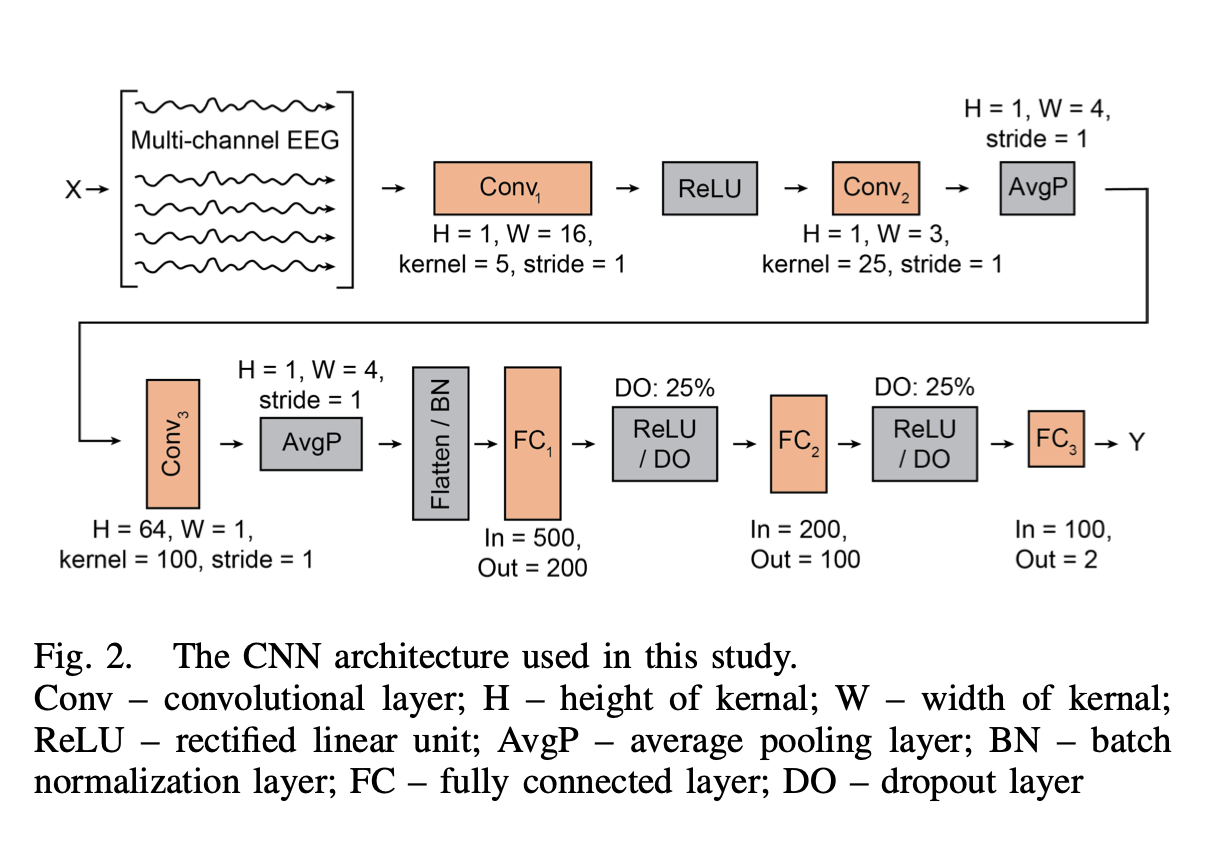

In [11]:
def cnn_ieee(train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100, ver = 1):
  train_X = train_X.reshape(-1, 32,101, 1)
  test_X = test_X.reshape(-1, 32,101, 1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)
  # batch_size = 32
  # epochs = 100
  num_classes = 2

  cnn_model = Sequential()
  cnn_model.add(Conv2D(5, kernel_size=(1, 16),activation='relu', input_shape=(32,101,1),padding='same'))
  # cnn_model.add(MaxPooling2D((2, 2),padding='same'))
  # cnn_model.add(BatchNormalization())
  # cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(25, (1, 3), activation='relu',padding='same'))
  cnn_model.add(AveragePooling2D(pool_size=(1, 4)))
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  # cnn_model.add(BatchNormalization())
  # cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(100, (1, 4), activation='relu',padding='same'))         
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  # cnn_model.add(BatchNormalization())
  # cnn_model.add(Dropout(0.25))

  cnn_model.add(Flatten())
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dense(200, activation='relu'))
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Dense(100, activation='relu'))
  cnn_model.add(Dropout(0.25))
  cnn_model.add(Dense(num_classes, activation='sigmoid'))

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  # opt = SGD(lr=0.0001)
  opt = Adam(lr=0.0001, decay=0.01)

  cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=ver,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = cnn_model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return cnn_model, cnn_train, test_eval, cm_cnn


In [21]:
def cnn(model, train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100, ver = 1):
  train_X = train_X.reshape(-1, 32, 101, 1)
  test_X = test_X.reshape(-1, 32, 101,1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)
  # batch_size = 32
  # epochs = 100
  num_classes = 2

  # set a valid path for your system to record model checkpoints
  # checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                              #  save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  opt = SGD(lr=0.01)
  # opt = Adam(lr=0.0001, decay=0.01)

  model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=ver,
                          validation_data=(valid_X, valid_label_categorical),
                          # callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return model, cnn_train, test_eval, cm_cnn


## AlexNet

In [13]:
def AlexNet():
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(10,4), strides=(1,1), activation='relu', input_shape=(32,101,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(10,4), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(5,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(5,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(5,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
  ])
  return model


## GoogleNet

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate
# https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (2,2), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (2,4), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((2,2), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (10, 101, 1))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (2,4), strides = 1, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (2,2), strides = 1)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (2,4), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (2,2), strides = 1)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (2,2), strides = 1)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (1,4), strides = 1)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(2, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (1,4), strides = 1)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(2, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (2,2), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(2, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

## EEGNET, ShallowNet, DeepNet

In [22]:
import keras
# keras.backend.set_image_data_format('channels_first')
"""
 ARL_EEGModels - A collection of Convolutional Neural Network models for EEG
 Signal Processing and Classification, using Keras and Tensorflow

 Requirements:
    (1) Tensorflow == 1.9.0
    (2) 'image_data_format' = 'channels_first' in keras.json config
    (3) Data shape = (trials, kernels, channels, samples), which for the 
        input layer, will be (trials, 1, channels, samples). 
    
 To use:
    
    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)
    (2) Import the model as
        
        from EEGModels import EEGNet    
        
        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)
        
    (3) Then compile and fit the model
    
        model.compile(loss = ..., optimizer = ..., metrics = ...)
        fitted    = model.fit(...)
        predicted = model.predict(...)


 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those 
 portions are released world-wide under the terms of the Creative Commons Zero 
 1.0 (CC0) license.  
 
 Other portions of this project are subject to domestic copyright protection 
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0 
 license.  The complete text of the license governing this material is in 
 the file labeled LICENSE.TXT that is a part of this project's official 
 distribution. 
"""

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.25, kernLength = 32, F1 = 4, 
             D = 2, F2 = 8, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-4,2 model as discussed
    in the paper. This model should do pretty well in general, although as the
    paper discussed the EEGNet-8,2 (with 8 temporal kernels and 2 spatial
    filters per temporal kernel) can do slightly better on the SMR dataset.
    Other variations that we found to work well are EEGNet-4,1 and EEGNet-8,1.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 4, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    if dropoutType == 'SpatialDropout2D':
      dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
      dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('relu')(block1)
    block1       = AveragePooling2D(pool_size=(1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('relu')(block2)
    block2       = AveragePooling2D(pool_size=(1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

## Get Model

In [16]:
def get_model(name):
  if name == "alexnet":
    model = AlexNet()

  if name == "googlenet":
    model = GoogLeNet()

  if name == "eegnet":
    model = EEGNet(nb_classes = 2, Chans = 32, Samples = 101)

  # if name == "enet":
  #   print("okay")
  
  return model

## Old

In [17]:
def cnn_101(train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100):
  train_X = train_X.reshape(-1, 10,101, 1)
  test_X = test_X.reshape(-1, 10,101, 1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)
  # batch_size = 32
  # epochs = 100
  num_classes = 2

  cnn_model = Sequential()
  cnn_model.add(Conv2D(8, kernel_size=(40, 4),activation='relu',input_shape=(10,101,1),padding='same'))
  # cnn_model.add(MaxPooling2D((2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(16, (80, 4), activation='relu',padding='same'))
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(32, (80, 4), activation='relu',padding='same'))         
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(num_classes, activation='sigmoid'))

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  opt = SGD(lr=0.01)
  #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

  cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=1,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = cnn_model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return cnn_model, cnn_train, test_eval, cm_cnn


## Visualization Functions

In [18]:
def vis_acc_loss(cnn_train):
  accuracy = cnn_train.history['accuracy']
  val_accuracy = cnn_train.history['val_accuracy']
  loss = cnn_train.history['loss']
  val_loss = cnn_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [19]:
def vis_confusion_matrix(cm):


  ax = sns.heatmap(cm, annot=True, 
            fmt='', cmap='Blues')
  
  # group_counts = ["{0:0.0f}".format(value) for value in
  #                 confusion_matrix.flatten()]

  # labels = [f"{v1}\n" for v1 in zip(group_counts)]

  # labels = np.asarray(labels).reshape(2,2)
  
  ax.set_title('CNN Confusion Matrix \n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['NI','AC'])
  ax.yaxis.set_ticklabels(['NI','AC'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()


# Test | All Subjects

In [ ]:
cnn_models = []
lda_models = []

## Test: LDA & CNN | Subject 1

In [ ]:
subject = 0

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 1.7s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.4s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.2s.


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


LDA

[[45 43]
 [31 45]]
Accuracy0.5487804878048781


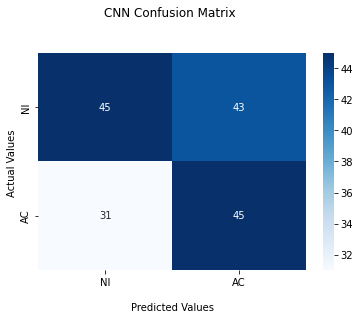

In [ ]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

CNN

In [ ]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_ieee(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y,
                                                  batch_size = 64,
                                                  epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5882
Epoch 1: val_loss improved from inf to 0.69090, saving model to /tmp/checkpoint.h5
8/8 [==============================] - 2s 205ms/step - loss: 0.6767 - accuracy: 0.5882 - val_loss: 0.6909 - val_accuracy: 0.6548
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.7386
Epoch 2: val_loss improved from 0.69090 to 0.68648, saving model to /tmp/checkpoint.h5
8/8 [==============================] - 1s 172ms/step - loss: 0.6335 - accuracy: 0.7386 - val_loss: 0.6865 - val_accuracy: 0.6447
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.7603
Epoch 3: val_loss improved from 0.68648 to 0.67799, saving model to /tmp/checkpoint.h5
8/8 [==============================] - 1s 172ms/step - loss: 0.5900 - accuracy: 0.7603 - val_loss: 0.6780 - val_accuracy: 0.6497
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8

In [ ]:
cnn_model.save("cnn_model_1.h5py")

INFO:tensorflow:Assets written to: cnn_model_1.h5py/assets


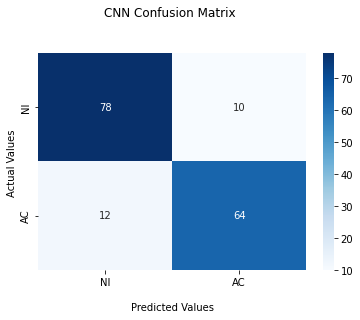

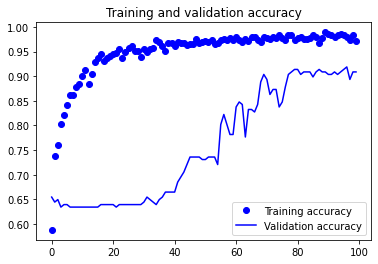

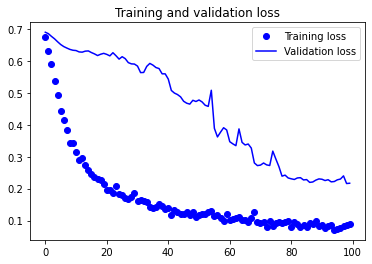

In [ ]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.32752278447151184
Test accuracy: 0.8658536672592163


With Autoencoder

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(train_X.shape[1]):
  scalers[i] = MinMaxScaler()
  # train_X[:, i, :] = sgolay2d(train_X[:, i, :], window_size=29, order=0)
  train_X[:, i, :] = scalers[i].fit_transform(train_X[:, i, :]) 

for i in range(test_X.shape[1]):
  # test_X[:, i, :] = sgolay2d(test_X[:, i, :], window_size=29, order=0)
  test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 

from keras.callbacks import TensorBoard

train_X = train_X.reshape(-1, 10,100, 1)
test_X = test_X.reshape(-1, 10,100, 1)


en = encoder(train_X, test_X, train_y, test_y)

en.fit(train_X, train_X,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(test_X, test_X))
en.save('/content/drive/MyDrive/databbci/encoder.h5')

train_X_predict = en.predict(train_X).reshape(-1, 10, 100)
test_X_predict = en.predict(test_X).reshape(-1, 10, 100)
train_X_predict.shape, test_X_predict.shape

Epoch 1/50
11/11 [==============================] - 2s 97ms/step - loss: 0.6942 - val_loss: 0.6915
Epoch 2/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6908 - val_loss: 0.6894
Epoch 3/50
11/11 [==============================] - 1s 82ms/step - loss: 0.6880 - val_loss: 0.6847
Epoch 4/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6778 - val_loss: 0.6603
Epoch 5/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6499 - val_loss: 0.6437
Epoch 6/50
11/11 [==============================] - 1s 81ms/step - loss: 0.6437 - val_loss: 0.6427
Epoch 7/50
11/11 [==============================] - 1s 83ms/step - loss: 0.6410 - val_loss: 0.6398
Epoch 8/50
11/11 [==============================] - 1s 82ms/step - loss: 0.6381 - val_loss: 0.6370
Epoch 9/50
11/11 [==============================] - 1s 82ms/step - loss: 0.6358 - val_loss: 0.6352
Epoch 10/50
11/11 [==============================] - 1s 81ms/step - loss: 0.6336 - val_loss: 0.6322
Epoch 11/

((656, 10, 100), (164, 10, 100))

[[56 32]
 [29 47]]
Accuracy0.6280487804878049


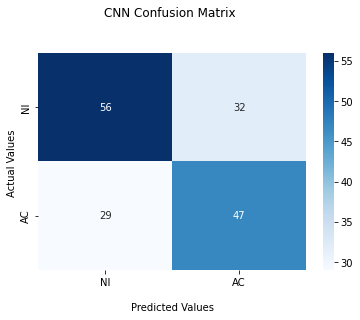

In [ ]:
clf_lda, cm_lda = lda_101(train_X_predict, test_X_predict, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model_tune, cnn_train_tune, test_eval_tune, cm_cnn_tune = cnn_ieee(train_X_predict, 
                                                                      test_X_predict, 
                                                                      train_y, 
                                                                      test_y,
                                                                      batch_size = 32,
                                                                      epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


15/15 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.6231
Epoch 1: val_loss improved from inf to 0.69262, saving model to /tmp/checkpoint.h5
15/15 [==============================] - 4s 201ms/step - loss: 0.6711 - accuracy: 0.6231 - val_loss: 0.6926 - val_accuracy: 0.5076
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6667
Epoch 2: val_loss improved from 0.69262 to 0.68659, saving model to /tmp/checkpoint.h5
15/15 [==============================] - 2s 114ms/step - loss: 0.6213 - accuracy: 0.6667 - val_loss: 0.6866 - val_accuracy: 0.6447
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7211
Epoch 3: val_loss improved from 0.68659 to 0.68501, saving model to /tmp/checkpoint.h5
15/15 [==============================] - 2s 117ms/step - loss: 0.5843 - accuracy: 0.7211 - val_loss: 0.6850 - val_accuracy: 0.6497
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.5598 -

In [ ]:
print('Test loss:', test_eval_tune[0])
print('Test accuracy:', test_eval_tune[1])

Test loss: 0.5995848774909973
Test accuracy: 0.707317054271698


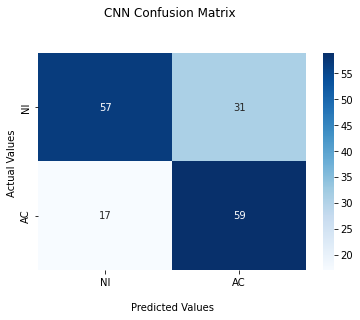

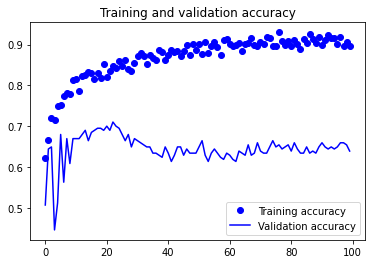

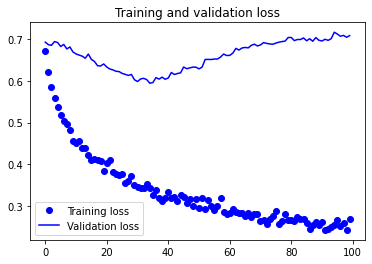

In [ ]:
vis_confusion_matrix(cm_cnn_tune)

vis_acc_loss(cnn_train_tune)

## LDA & CNN | Subject 2

In [ ]:
subject = 1

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 1.8s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.5s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.9s.


In [ ]:
from collections import Counter
print(Counter(train_y))
print(Counter(test_y))

Counter({1: 372, 2: 284})
Counter({1: 88, 2: 76})


No handles with labels found to put in legend.


1


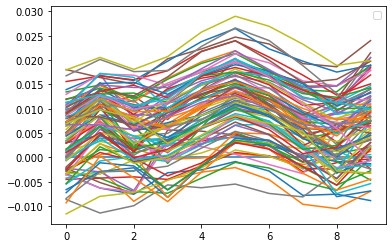

In [ ]:
n = 10
print(train_y[n])
plt.plot(train_X[n,:,:])
plt.legend()
plt.show()

[[48 40]
 [36 40]]
Accuracy0.5365853658536586


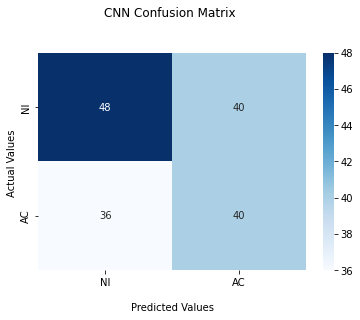

In [ ]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_ieee(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y,
                                                  28,
                                                  epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


17/17 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.5839
Epoch 1: val_loss improved from inf to 0.71531, saving model to /tmp/checkpoint.h5
17/17 [==============================] - 4s 168ms/step - loss: 0.7959 - accuracy: 0.5839 - val_loss: 0.7153 - val_accuracy: 0.3756
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.6231
Epoch 2: val_loss improved from 0.71531 to 0.71503, saving model to /tmp/checkpoint.h5
17/17 [==============================] - 2s 108ms/step - loss: 0.7037 - accuracy: 0.6231 - val_loss: 0.7150 - val_accuracy: 0.3655
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.6471
Epoch 3: val_loss improved from 0.71503 to 0.68394, saving model to /tmp/checkpoint.h5
17/17 [==============================] - 2s 113ms/step - loss: 0.6662 - accuracy: 0.6471 - val_loss: 0.6839 - val_accuracy: 0.6548
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 0.6240 -

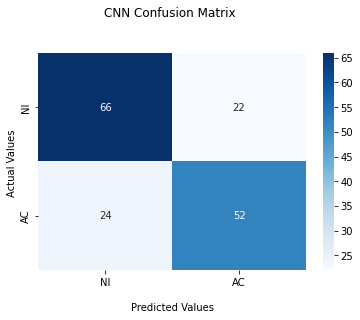

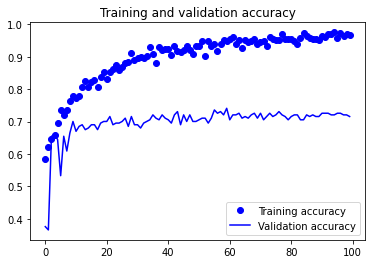

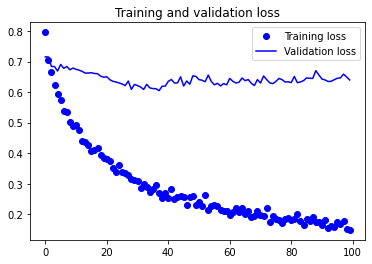

In [ ]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6839898228645325
Test accuracy: 0.7195122241973877


With Autoencoder

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(train_X.shape[1]):
  scalers[i] = MinMaxScaler()
  # train_X[:, i, :] = sgolay2d(train_X[:, i, :], window_size=29, order=0)
  train_X[:, i, :] = scalers[i].fit_transform(train_X[:, i, :]) 

for i in range(test_X.shape[1]):
  # test_X[:, i, :] = sgolay2d(test_X[:, i, :], window_size=29, order=0)
  test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 

In [ ]:
from keras.callbacks import TensorBoard

train_X = train_X.reshape(-1, 10,100, 1)
test_X = test_X.reshape(-1, 10,100, 1)


en = encoder(train_X, test_X, train_y, test_y)

en.fit(train_X, train_X,
                epochs=50,
                batch_size=len(train_X),
                shuffle=True,
                validation_data=(test_X, test_X))
# en.save('/content/drive/MyDrive/databbci/encoder.h5')

train_X_predict = en.predict(train_X).reshape(-1, 10, 100)
test_X_predict = en.predict(test_X).reshape(-1, 10, 100)
train_X_predict.shape, test_X_predict.shape

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6926 - val_loss: 0.6922
Epoch 2/50
1/1 [==============================] - 1s 775ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 3/50
1/1 [==============================] - 1s 786ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 4/50
1/1 [==============================] - 1s 783ms/step - loss: 0.6904 - val_loss: 0.6907
Epoch 5/50
1/1 [==============================] - 1s 806ms/step - loss: 0.6898 - val_loss: 0.6903
Epoch 6/50
1/1 [==============================] - 1s 766ms/step - loss: 0.6891 - val_loss: 0.6899
Epoch 7/50
1/1 [==============================] - 1s 773ms/step - loss: 0.6885 - val_loss: 0.6897
Epoch 8/50
1/1 [==============================] - 1s 772ms/step - loss: 0.6880 - val_loss: 0.6895
Epoch 9/50
1/1 [==============================] - 1s 780ms/step - loss: 0.6875 - val_loss: 0.6894
Epoch 10/50
1/1 [==============================] - 1s 766ms/step - loss: 0.6871 - val_loss: 0.6893
Epoch 11/50
1/1 [=====

((656, 10, 100), (164, 10, 100))

No handles with labels found to put in legend.


1


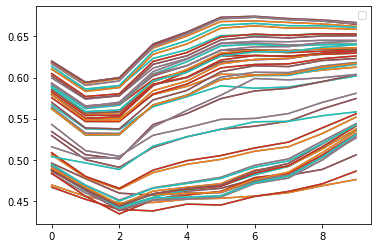

In [ ]:
n = 10
print(train_y[n])
plt.plot(train_X_predict[n,:,:])
plt.legend()
plt.show()

[[48 40]
 [42 34]]
Accuracy0.5


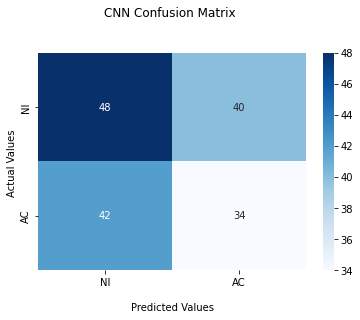

In [ ]:
clf_lda, cm_lda = lda_101(train_X_predict, test_X_predict, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model_tune, cnn_train_tune, test_eval_tune, cm_cnn_tune = cnn_ieee(train_X_predict, 
                                                                      test_X_predict, 
                                                                      train_y, 
                                                                      test_y,
                                                                      30,
                                                                      epochs = 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


16/16 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.5926
Epoch 1: val_loss improved from inf to 0.68893, saving model to /tmp/checkpoint.h5
16/16 [==============================] - 3s 131ms/step - loss: 0.7494 - accuracy: 0.5926 - val_loss: 0.6889 - val_accuracy: 0.6650
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.5664
Epoch 2: val_loss improved from 0.68893 to 0.68432, saving model to /tmp/checkpoint.h5
16/16 [==============================] - 2s 108ms/step - loss: 0.7226 - accuracy: 0.5664 - val_loss: 0.6843 - val_accuracy: 0.6599
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.5817
Epoch 3: val_loss improved from 0.68432 to 0.66513, saving model to /tmp/checkpoint.h5
16/16 [==============================] - 2s 108ms/step - loss: 0.6969 - accuracy: 0.5817 - val_loss: 0.6651 - val_accuracy: 0.6345
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.6649 -

In [ ]:
cnn_model.save("'/content/drive/MyDrive/databbci/cnn_model_2.h5py")

INFO:tensorflow:Assets written to: cnn_model_2.h5py/assets


In [ ]:
tmp = test_X[1].reshape(10,100,1)
print(tmp.shape)
print(cnn_model.predict(test_X, batch_size=124))
print(test_y[0])

(10, 100, 1)
[[0.5403531  0.48561817]
 [0.5415746  0.4909963 ]
 [0.54061717 0.48333442]
 [0.51923364 0.46938333]
 [0.49795803 0.4612712 ]
 [0.50289845 0.4622757 ]
 [0.49072927 0.4576956 ]
 [0.4907297  0.46066827]
 [0.4796159  0.46966064]
 [0.46928328 0.48880368]
 [0.48206773 0.49015945]
 [0.4714606  0.47603628]
 [0.4992634  0.50201756]
 [0.4876756  0.49893892]
 [0.47816068 0.512499  ]
 [0.4670898  0.4734745 ]
 [0.46107566 0.4848306 ]
 [0.46641317 0.4629807 ]
 [0.4763867  0.4868711 ]
 [0.49037626 0.4872207 ]
 [0.49332973 0.48633417]
 [0.49477106 0.4879439 ]
 [0.47194052 0.48111084]
 [0.49485743 0.48671135]
 [0.47714233 0.48078015]
 [0.48231283 0.4811642 ]
 [0.465384   0.48133934]
 [0.45366398 0.47529218]
 [0.46342173 0.47402674]
 [0.4692192  0.4685071 ]
 [0.48368755 0.47206348]
 [0.4961835  0.4802755 ]
 [0.49994567 0.4803313 ]
 [0.49847975 0.48588938]
 [0.49607497 0.4817906 ]
 [0.49901068 0.48632705]
 [0.49504697 0.5025257 ]
 [0.5014696  0.48324454]
 [0.49272567 0.48644996]
 [0.4971585 

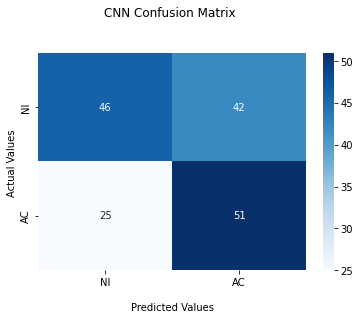

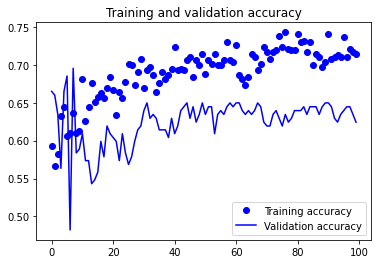

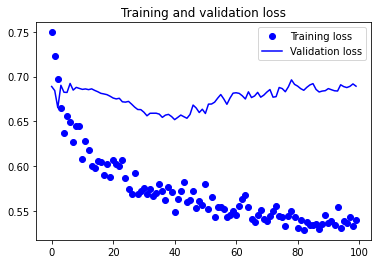

In [ ]:
vis_confusion_matrix(cm_cnn_tune)

vis_acc_loss(cnn_train_tune)

In [ ]:
print('Test loss:', test_eval_tune[0])
print('Test accuracy:', test_eval_tune[1])

Test loss: 0.658076286315918
Test accuracy: 0.5914633870124817


## Test 3: LDA & CNN | Subject 3

In [ ]:
subject = 2

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 1.1s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.6s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components


<ipython-input-5-9e9bb564ee4f>:32: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.3s.


[[53 40]
 [34 31]]
Accuracy0.5316455696202531


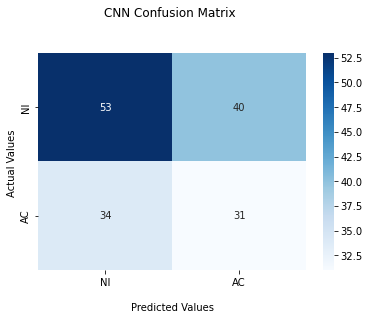

In [ ]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [ ]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_ieee(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y, 124 , 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4/5 [=======================>......] - ETA: 0s - loss: 0.5551 - accuracy: 0.6673
Epoch 1: val_loss improved from inf to 0.63215, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 2s 295ms/step - loss: 0.5537 - accuracy: 0.6693 - val_loss: 0.6321 - val_accuracy: 0.5906
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.7545
Epoch 2: val_loss improved from 0.63215 to 0.62342, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 1s 254ms/step - loss: 0.4590 - accuracy: 0.7545 - val_loss: 0.6234 - val_accuracy: 0.5906
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8198
Epoch 3: val_loss did not improve from 0.62342
5/5 [==============================] - 1s 218ms/step - loss: 0.4446 - accuracy: 0.8198 - val_loss: 0.6236 - val_accuracy: 0.5906
Epoch 4/100
4/5 [=======================>......] - ETA: 0s - loss: 0.4070 - accuracy: 0.8286
Epoch 4: val_loss improved from 0.62

In [ ]:
cnn_model.save("/content/drive/MyDrive/databbci/cnn_model_3_90.h5py")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/databbci/cnn_model_3_90.h5py/assets


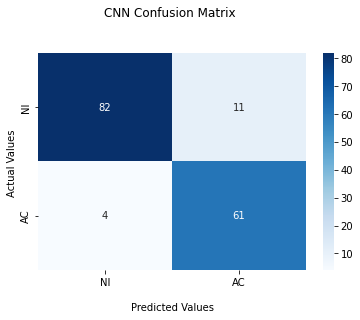

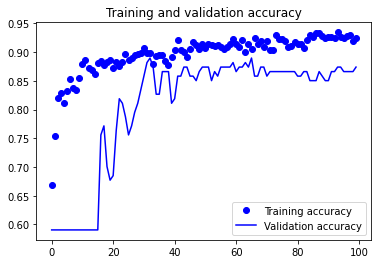

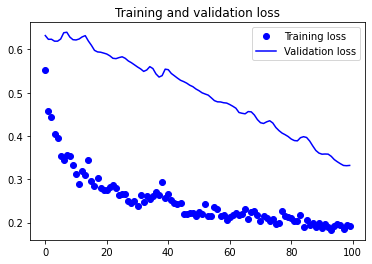

In [ ]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.30953121185302734
Test accuracy: 0.905063271522522


With autoencoder

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy

scalers = {}
for i in range(train_X.shape[1]):
  scalers[i] = MinMaxScaler()
  # train_X[:, i, :] = sgolay2d(train_X[:, i, :], window_size=29, order=0)
  train_X[:, i, :] = scalers[i].fit_transform(train_X[:, i, :]) 

for i in range(test_X.shape[1]):
  # test_X[:, i, :] = sgolay2d(test_X[:, i, :], window_size=29, order=0)
  test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 

from keras.callbacks import TensorBoard

train_X = train_X.reshape(-1, 10,100, 1)
test_X = test_X.reshape(-1, 10,100, 1)


en = encoder(train_X, test_X, train_y, test_y)

en.fit(train_X, train_X,
                epochs=50,
                batch_size=len(train_X),
                shuffle=True,
                validation_data=(test_X, test_X))
en.save('/content/drive/MyDrive/databbci/encoder.h5')

train_X_predict = en.predict(train_X).reshape(-1, 10, 100)
test_X_predict = en.predict(test_X).reshape(-1, 10, 100)
train_X_predict.shape, test_X_predict.shape

Epoch 1/50
5/5 [==============================] - 2s 207ms/step - loss: 0.6871 - val_loss: 0.6801
Epoch 2/50
5/5 [==============================] - 1s 170ms/step - loss: 0.6746 - val_loss: 0.6725
Epoch 3/50
5/5 [==============================] - 1s 175ms/step - loss: 0.6724 - val_loss: 0.6725
Epoch 4/50
5/5 [==============================] - 1s 192ms/step - loss: 0.6700 - val_loss: 0.6713
Epoch 5/50
5/5 [==============================] - 1s 192ms/step - loss: 0.6701 - val_loss: 0.6704
Epoch 6/50
5/5 [==============================] - 1s 172ms/step - loss: 0.6686 - val_loss: 0.6696
Epoch 7/50
5/5 [==============================] - 1s 169ms/step - loss: 0.6677 - val_loss: 0.6682
Epoch 8/50
5/5 [==============================] - 1s 170ms/step - loss: 0.6665 - val_loss: 0.6671
Epoch 9/50
5/5 [==============================] - 1s 171ms/step - loss: 0.6652 - val_loss: 0.6657
Epoch 10/50
5/5 [==============================] - 1s 172ms/step - loss: 0.6635 - val_loss: 0.6637
Epoch 11/50
5/5 [==

((632, 10, 100), (158, 10, 100))

[[58 35]
 [17 48]]
Accuracy0.6708860759493671


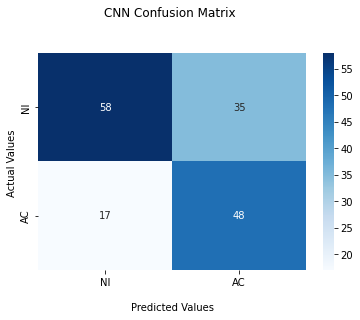

In [ ]:
clf_lda, cm_lda = lda_101(train_X_predict, test_X_predict, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

No handles with labels found to put in legend.


1


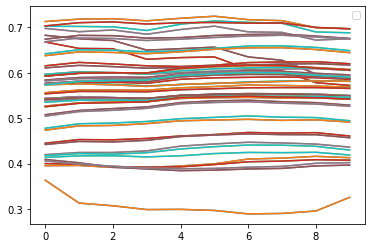

In [ ]:
n = 100
print(train_y[n])
plt.plot(train_X_predict[n,:,:])
plt.legend()
plt.show()

In [ ]:
cnn_model_tune, cnn_train_tune, test_eval_tune, cm_cnn_tune = cnn_ieee(train_X_predict, 
                                                                      test_X_predict, 
                                                                      train_y, 
                                                                      test_y, 124 , 100)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6059
Epoch 1: val_loss improved from inf to 0.68424, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 2s 344ms/step - loss: 0.6364 - accuracy: 0.6059 - val_loss: 0.6842 - val_accuracy: 0.5906
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7525
Epoch 2: val_loss improved from 0.68424 to 0.67352, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 1s 280ms/step - loss: 0.5004 - accuracy: 0.7525 - val_loss: 0.6735 - val_accuracy: 0.5906
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.7941
Epoch 3: val_loss improved from 0.67352 to 0.66533, saving model to /tmp/checkpoint.h5
5/5 [==============================] - 1s 271ms/step - loss: 0.4845 - accuracy: 0.7941 - val_loss: 0.6653 - val_accuracy: 0.5906
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.7

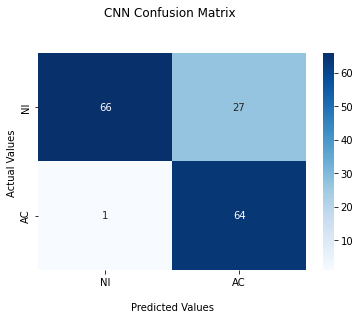

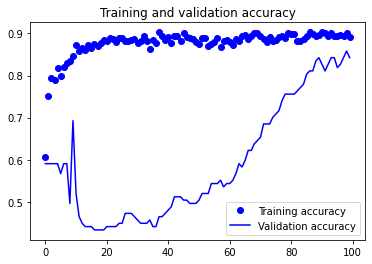

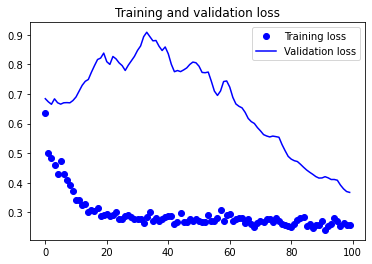

In [ ]:
vis_confusion_matrix(cm_cnn_tune)

vis_acc_loss(cnn_train_tune)

In [ ]:
print('Test loss:', test_eval_tune[0])
print('Test accuracy:', test_eval_tune[1])

Test loss: 0.37530481815338135
Test accuracy: 0.8227847814559937


# All subjects | Auditory

In [ ]:
for i in range(14):
  print('**************************************************')
  print('Subject', i)
  train_X, test_X, train_y, test_y = get_train_test(active_au[i], passive_au[i], cue_au[i])

  # LDA
  clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
  vis_confusion_matrix(cm_lda)

  #CNN
  cnn_model, cnn_train, test_eval, cm_cnn = cnn_ieee(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y,
                                                  batch_size = 64,
                                                  epochs = 100,
                                                  ver = 1)
  
  vis_confusion_matrix(cm_cnn)
  vis_acc_loss(cnn_train)
  print('Test loss:', test_eval[0])
  print('Test accuracy:', test_eval[1])
  print('**************************************************')

In [ ]:
train_X, test_X, train_y, test_y = get_train_test(active_au[i], passive_au[i], cue_au[i])
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(540, 32, 101) (280, 32, 101) (540,) (280,)


**************************************************
Subject 0
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 3s 132ms/step - loss: 0.6944 - accuracy: 0.4907 - val_loss: 0.6909 - val_accuracy: 0.7130
Epoch 2/100
14/14 [==============================] - 1s 92ms/step - loss: 0.6903 - accuracy: 0.4977 - val_loss: 0.6890 - val_accuracy: 0.7037
Epoch 3/100
14/14 [==============================] - 1s 93ms/step - loss: 0.6812 - accuracy: 0.5324 - val_loss: 0.6866 - val_accuracy: 0.7037
Epoch 4/100
14/14 [==============================] - 1s 90ms/step - loss: 0.6856 - accuracy: 0.5301 - val_loss: 0.6835 - val_accuracy: 0.7037
Epoch 5/100
14/14 [==============================] - 1s 89ms/step - loss: 0.6808 - accuracy: 0.5440 - val_loss: 0.6807 - val_accuracy: 0.7037
Epoch 6/100
14/14 [==============================] - 1s 91ms/step - loss: 0.6828 - accuracy: 0.5486 - val_loss: 0.6787 - val_accuracy: 0.7037
Epoch 7/100
14/14 [==============================] - 1s 90ms/step - loss: 0.6796 - accuracy: 0.5741 - val_loss: 0.6770 - val_accuracy: 0.7037
Epoch 8/100
14/14

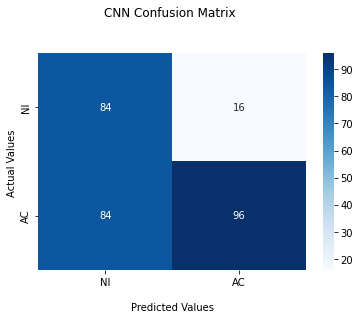

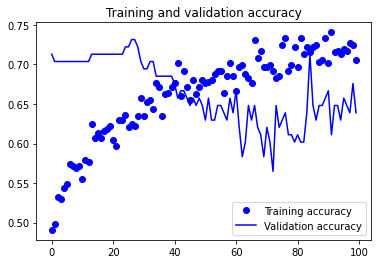

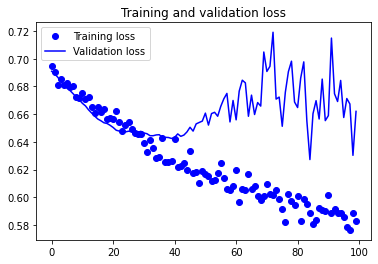

Test loss: 0.6042730808258057
Test accuracy: 0.6428571343421936
**************************************************
**************************************************
Subject 1
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 112ms/step - loss: 0.6778 - accuracy: 0.5995 - val_loss: 0.6938 - val_accuracy: 0.3426
Epoch 2/100
14/14 [==============================] - 1s 95ms/step - loss: 0.6539 - accuracy: 0.6991 - val_loss: 0.6954 - val_accuracy: 0.3333
Epoch 3/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6299 - accuracy: 0.7292 - val_loss: 0.6982 - val_accuracy: 0.3056
Epoch 4/100
14/14 [==============================] - 1s 94ms/step - loss: 0.6107 - accuracy: 0.7917 - val_loss: 0.7005 - val_accuracy: 0.3056
Epoch 5/100
14/14 [==============================] - 1s 94ms/step - loss: 0.5989 - accuracy: 0.7870 - val_loss: 0.7045 - val_accuracy: 0.2963
Epoch 6/100
14/14 [==============================] - 1s 95ms/step - loss: 0.5912 - accuracy: 0.7801 - val_loss: 0.7081 - val_accuracy: 0.2963
Epoch 7/100
14/14 [==============================] - 1s 94ms/step - loss: 0.5827 - accuracy: 0.8032 - val_loss: 0.7126 - val_accuracy: 0.2963
Epoch 8/100
14/14

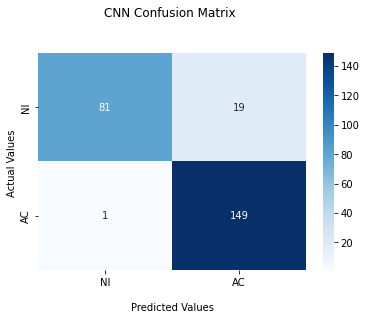

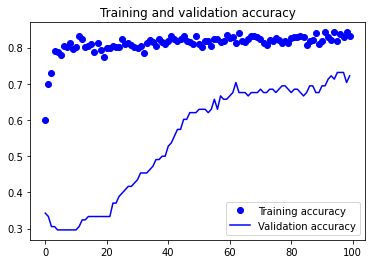

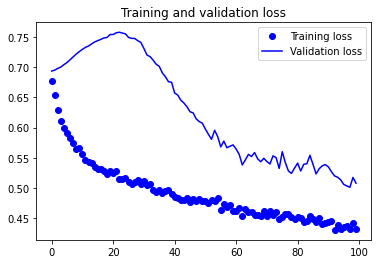

Test loss: 0.37231379747390747
Test accuracy: 0.9200000166893005
**************************************************
**************************************************
Subject 2
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 111ms/step - loss: 0.7018 - accuracy: 0.6204 - val_loss: 0.6945 - val_accuracy: 0.3704
Epoch 2/100
14/14 [==============================] - 1s 94ms/step - loss: 0.6977 - accuracy: 0.5718 - val_loss: 0.6949 - val_accuracy: 0.3704
Epoch 3/100
14/14 [==============================] - 1s 94ms/step - loss: 0.6954 - accuracy: 0.5741 - val_loss: 0.6948 - val_accuracy: 0.3704
Epoch 4/100
14/14 [==============================] - 1s 95ms/step - loss: 0.6927 - accuracy: 0.5671 - val_loss: 0.6949 - val_accuracy: 0.3704
Epoch 5/100
14/14 [==============================] - 1s 93ms/step - loss: 0.6980 - accuracy: 0.5625 - val_loss: 0.6946 - val_accuracy: 0.3704
Epoch 6/100
14/14 [==============================] - 1s 92ms/step - loss: 0.6896 - accuracy: 0.5602 - val_loss: 0.6938 - val_accuracy: 0.3704
Epoch 7/100
14/14 [==============================] - 1s 93ms/step - loss: 0.6918 - accuracy: 0.5926 - val_loss: 0.6942 - val_accuracy: 0.3704
Epoch 8/100
14/14

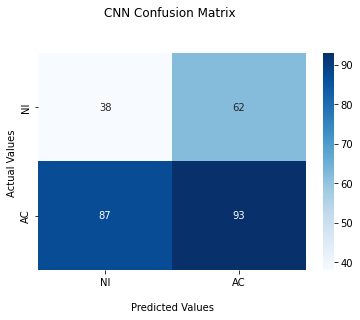

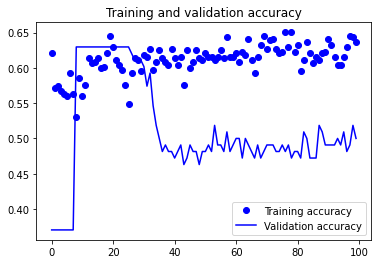

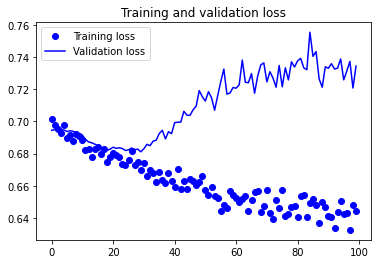

Test loss: 0.7270916700363159
Test accuracy: 0.46785715222358704
**************************************************
**************************************************
Subject 3
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 112ms/step - loss: 0.7094 - accuracy: 0.5833 - val_loss: 0.6944 - val_accuracy: 0.3796
Epoch 2/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6961 - accuracy: 0.4954 - val_loss: 0.6941 - val_accuracy: 0.3796
Epoch 3/100
14/14 [==============================] - 1s 98ms/step - loss: 0.6918 - accuracy: 0.5833 - val_loss: 0.6943 - val_accuracy: 0.3796
Epoch 4/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6895 - accuracy: 0.5301 - val_loss: 0.6935 - val_accuracy: 0.3796
Epoch 5/100
14/14 [==============================] - 1s 99ms/step - loss: 0.6892 - accuracy: 0.5394 - val_loss: 0.6929 - val_accuracy: 0.6204
Epoch 6/100
14/14 [==============================] - 1s 94ms/step - loss: 0.6902 - accuracy: 0.5625 - val_loss: 0.6923 - val_accuracy: 0.6204
Epoch 7/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6843 - accuracy: 0.5856 - val_loss: 0.6919 - val_accuracy: 0.6204
Epoch 8/100
14/14

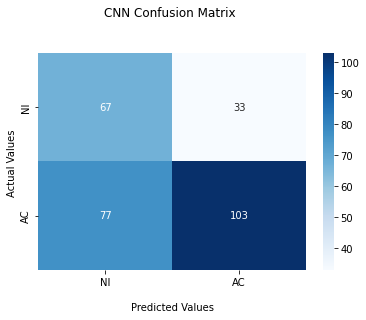

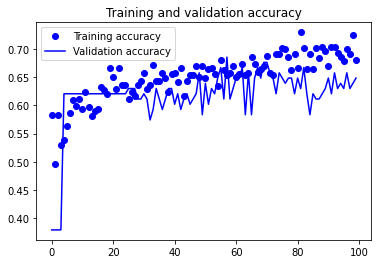

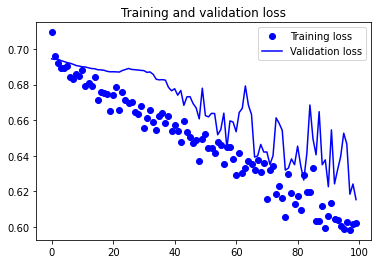

Test loss: 0.6797129511833191
Test accuracy: 0.6071428656578064
**************************************************
**************************************************
Subject 4
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 112ms/step - loss: 0.7117 - accuracy: 0.4282 - val_loss: 0.6918 - val_accuracy: 0.6667
Epoch 2/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6959 - accuracy: 0.4653 - val_loss: 0.6907 - val_accuracy: 0.6667
Epoch 3/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6971 - accuracy: 0.4329 - val_loss: 0.6893 - val_accuracy: 0.6667
Epoch 4/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6884 - accuracy: 0.4954 - val_loss: 0.6884 - val_accuracy: 0.6667
Epoch 5/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6872 - accuracy: 0.4838 - val_loss: 0.6871 - val_accuracy: 0.6667
Epoch 6/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6993 - accuracy: 0.4468 - val_loss: 0.6861 - val_accuracy: 0.6667
Epoch 7/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6880 - accuracy: 0.5093 - val_loss: 0.6850 - val_accuracy: 0.6667
Epoch 8/100
14/1

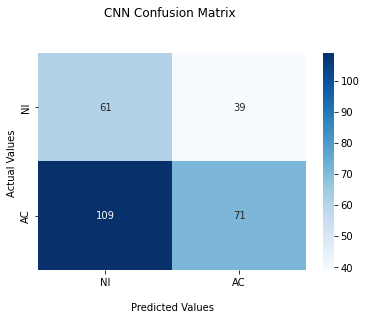

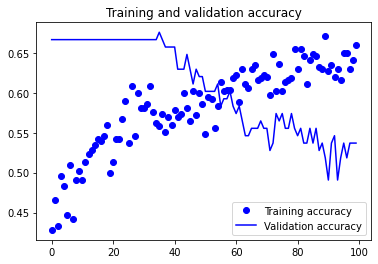

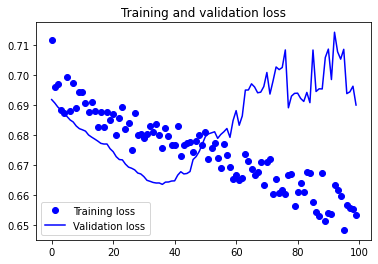

Test loss: 0.7239553928375244
Test accuracy: 0.4714285731315613
**************************************************
**************************************************
Subject 5
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 113ms/step - loss: 0.7024 - accuracy: 0.5926 - val_loss: 0.6958 - val_accuracy: 0.3333
Epoch 2/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6971 - accuracy: 0.5394 - val_loss: 0.6973 - val_accuracy: 0.3333
Epoch 3/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6883 - accuracy: 0.5093 - val_loss: 0.6985 - val_accuracy: 0.3333
Epoch 4/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6856 - accuracy: 0.5463 - val_loss: 0.6999 - val_accuracy: 0.3333
Epoch 5/100
14/14 [==============================] - 1s 99ms/step - loss: 0.6875 - accuracy: 0.5116 - val_loss: 0.7010 - val_accuracy: 0.3333
Epoch 6/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6905 - accuracy: 0.4630 - val_loss: 0.7020 - val_accuracy: 0.3333
Epoch 7/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6907 - accuracy: 0.4815 - val_loss: 0.7033 - val_accuracy: 0.3333
Epoch 8/100
14/14

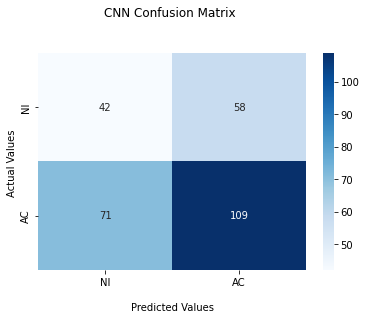

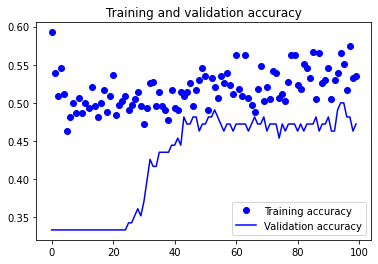

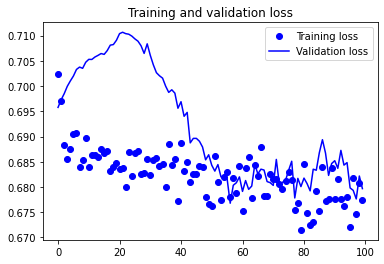

Test loss: 0.6994684338569641
Test accuracy: 0.5392857193946838
**************************************************
**************************************************
Subject 6
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 110ms/step - loss: 0.6959 - accuracy: 0.5255 - val_loss: 0.6944 - val_accuracy: 0.3148
Epoch 2/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6929 - accuracy: 0.5625 - val_loss: 0.6954 - val_accuracy: 0.3056
Epoch 3/100
14/14 [==============================] - 1s 95ms/step - loss: 0.6865 - accuracy: 0.5370 - val_loss: 0.6963 - val_accuracy: 0.3056
Epoch 4/100
14/14 [==============================] - 1s 95ms/step - loss: 0.6865 - accuracy: 0.5787 - val_loss: 0.6978 - val_accuracy: 0.3056
Epoch 5/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6916 - accuracy: 0.5023 - val_loss: 0.6988 - val_accuracy: 0.3056
Epoch 6/100
14/14 [==============================] - 1s 98ms/step - loss: 0.6854 - accuracy: 0.5694 - val_loss: 0.7001 - val_accuracy: 0.3056
Epoch 7/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6873 - accuracy: 0.5880 - val_loss: 0.7018 - val_accuracy: 0.3056
Epoch 8/100
14/14

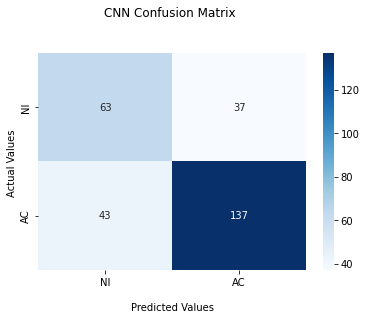

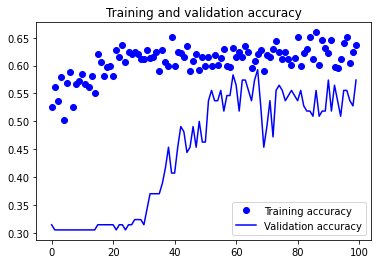

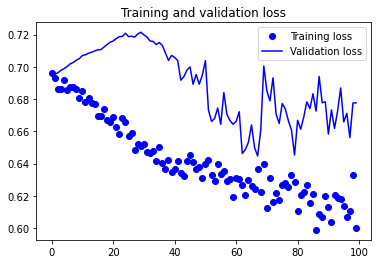

Test loss: 0.6096746921539307
Test accuracy: 0.7142857313156128
**************************************************
**************************************************
Subject 7
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 113ms/step - loss: 0.7190 - accuracy: 0.3704 - val_loss: 0.6925 - val_accuracy: 0.6759
Epoch 2/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6974 - accuracy: 0.4329 - val_loss: 0.6925 - val_accuracy: 0.6759
Epoch 3/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6957 - accuracy: 0.4444 - val_loss: 0.6920 - val_accuracy: 0.6759
Epoch 4/100
14/14 [==============================] - 1s 99ms/step - loss: 0.6963 - accuracy: 0.4838 - val_loss: 0.6925 - val_accuracy: 0.6759
Epoch 5/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6998 - accuracy: 0.4606 - val_loss: 0.6929 - val_accuracy: 0.6667
Epoch 6/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6935 - accuracy: 0.4769 - val_loss: 0.6934 - val_accuracy: 0.3796
Epoch 7/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6971 - accuracy: 0.4722 - val_loss: 0.6927 - val_accuracy: 0.6759
Epoch 8/100
14/14

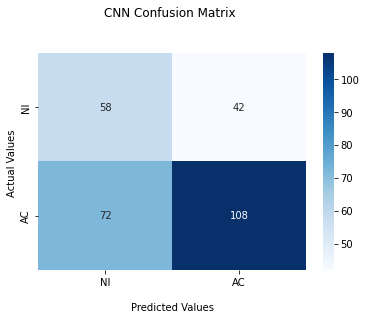

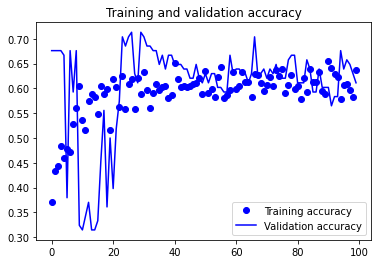

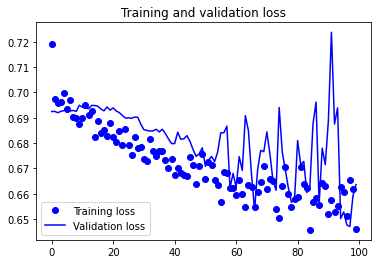

Test loss: 0.6776219606399536
Test accuracy: 0.5928571224212646
**************************************************
**************************************************
Subject 8
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 112ms/step - loss: 0.7321 - accuracy: 0.4097 - val_loss: 0.6932 - val_accuracy: 0.3611
Epoch 2/100
14/14 [==============================] - 1s 97ms/step - loss: 0.7042 - accuracy: 0.3958 - val_loss: 0.6931 - val_accuracy: 0.6481
Epoch 3/100
14/14 [==============================] - 1s 95ms/step - loss: 0.6999 - accuracy: 0.4375 - val_loss: 0.6934 - val_accuracy: 0.3426
Epoch 4/100
14/14 [==============================] - 1s 95ms/step - loss: 0.6970 - accuracy: 0.4491 - val_loss: 0.6930 - val_accuracy: 0.6759
Epoch 5/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6934 - accuracy: 0.5093 - val_loss: 0.6936 - val_accuracy: 0.3333
Epoch 6/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6895 - accuracy: 0.5579 - val_loss: 0.6943 - val_accuracy: 0.3333
Epoch 7/100
14/14 [==============================] - 1s 98ms/step - loss: 0.6898 - accuracy: 0.5718 - val_loss: 0.6951 - val_accuracy: 0.3333
Epoch 8/100
14/14

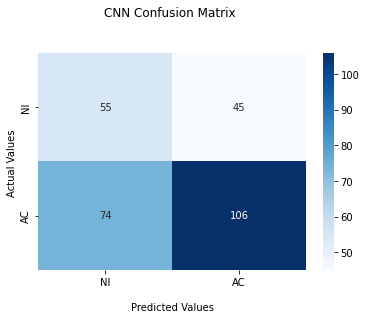

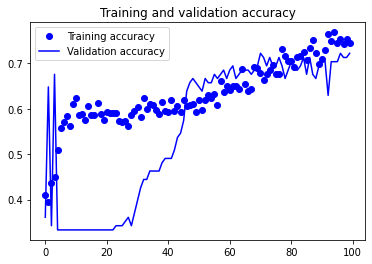

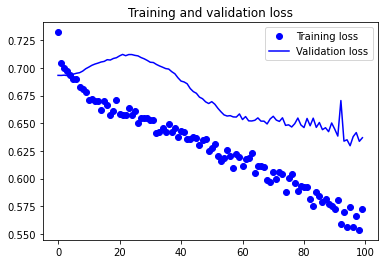

Test loss: 0.7133381962776184
Test accuracy: 0.574999988079071
**************************************************
**************************************************
Subject 9
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 114ms/step - loss: 0.7092 - accuracy: 0.3495 - val_loss: 0.6905 - val_accuracy: 0.6852
Epoch 2/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6947 - accuracy: 0.3935 - val_loss: 0.6902 - val_accuracy: 0.6852
Epoch 3/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6971 - accuracy: 0.4074 - val_loss: 0.6896 - val_accuracy: 0.6852
Epoch 4/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6974 - accuracy: 0.4375 - val_loss: 0.6900 - val_accuracy: 0.6852
Epoch 5/100
14/14 [==============================] - 1s 98ms/step - loss: 0.6932 - accuracy: 0.4306 - val_loss: 0.6897 - val_accuracy: 0.6852
Epoch 6/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6945 - accuracy: 0.4120 - val_loss: 0.6903 - val_accuracy: 0.6852
Epoch 7/100
14/14 [==============================] - 1s 99ms/step - loss: 0.7000 - accuracy: 0.4028 - val_loss: 0.6901 - val_accuracy: 0.6852
Epoch 8/100
14/14

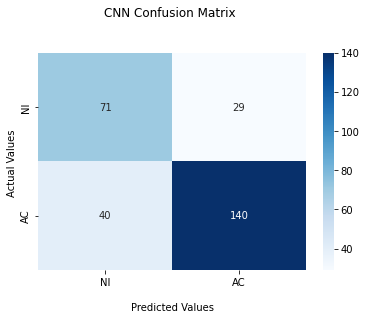

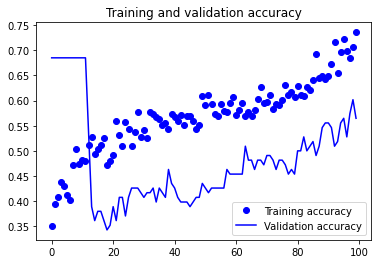

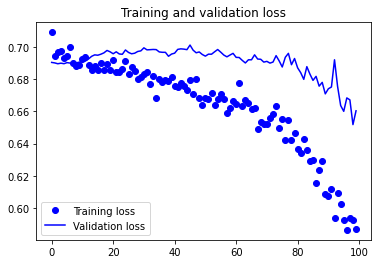

Test loss: 0.5498976111412048
Test accuracy: 0.7535714507102966
**************************************************
**************************************************
Subject 10
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 119ms/step - loss: 0.7119 - accuracy: 0.4444 - val_loss: 0.6920 - val_accuracy: 0.6667
Epoch 2/100
14/14 [==============================] - 1s 100ms/step - loss: 0.6944 - accuracy: 0.4306 - val_loss: 0.6910 - val_accuracy: 0.6667
Epoch 3/100
14/14 [==============================] - 1s 100ms/step - loss: 0.6954 - accuracy: 0.4306 - val_loss: 0.6900 - val_accuracy: 0.6667
Epoch 4/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6984 - accuracy: 0.4907 - val_loss: 0.6892 - val_accuracy: 0.6667
Epoch 5/100
14/14 [==============================] - 1s 98ms/step - loss: 0.6983 - accuracy: 0.4954 - val_loss: 0.6891 - val_accuracy: 0.6667
Epoch 6/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6973 - accuracy: 0.4884 - val_loss: 0.6880 - val_accuracy: 0.6667
Epoch 7/100
14/14 [==============================] - 1s 98ms/step - loss: 0.6946 - accuracy: 0.4792 - val_loss: 0.6879 - val_accuracy: 0.6667
Epoch 8/100
1

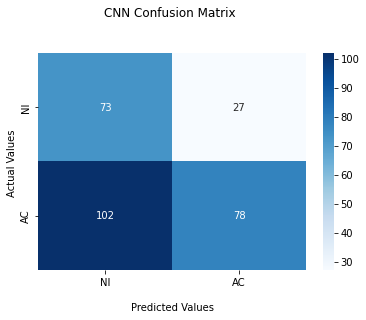

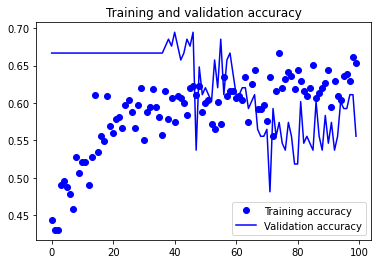

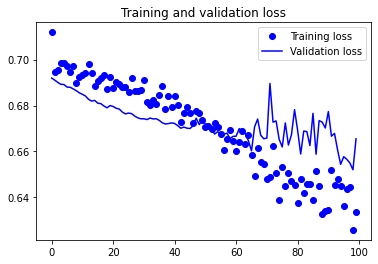

Test loss: 0.7047808766365051
Test accuracy: 0.5392857193946838
**************************************************
**************************************************
Subject 11
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 116ms/step - loss: 0.7152 - accuracy: 0.4699 - val_loss: 0.6935 - val_accuracy: 0.3333
Epoch 2/100
14/14 [==============================] - 1s 101ms/step - loss: 0.7024 - accuracy: 0.4236 - val_loss: 0.6935 - val_accuracy: 0.3333
Epoch 3/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6954 - accuracy: 0.4769 - val_loss: 0.6941 - val_accuracy: 0.3333
Epoch 4/100
14/14 [==============================] - 1s 102ms/step - loss: 0.6974 - accuracy: 0.4977 - val_loss: 0.6949 - val_accuracy: 0.3333
Epoch 5/100
14/14 [==============================] - 1s 100ms/step - loss: 0.6961 - accuracy: 0.5301 - val_loss: 0.6952 - val_accuracy: 0.3333
Epoch 6/100
14/14 [==============================] - 1s 99ms/step - loss: 0.6861 - accuracy: 0.5718 - val_loss: 0.6961 - val_accuracy: 0.3333
Epoch 7/100
14/14 [==============================] - 1s 99ms/step - loss: 0.6883 - accuracy: 0.5162 - val_loss: 0.6970 - val_accuracy: 0.3333
Epoch 8/100
1

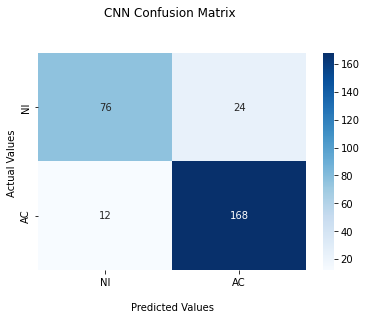

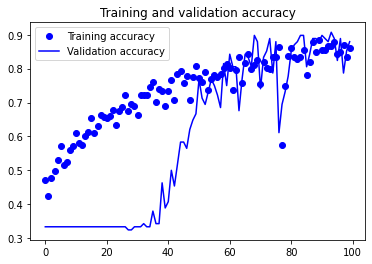

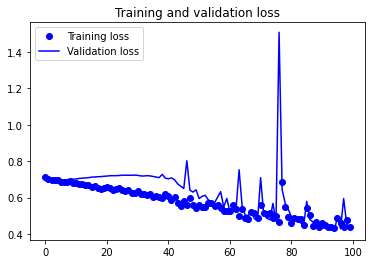

Test loss: 0.43578603863716125
Test accuracy: 0.8714285492897034
**************************************************
**************************************************
Subject 12
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 120ms/step - loss: 0.6992 - accuracy: 0.4468 - val_loss: 0.6925 - val_accuracy: 0.6574
Epoch 2/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6863 - accuracy: 0.4931 - val_loss: 0.6916 - val_accuracy: 0.6574
Epoch 3/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6936 - accuracy: 0.4792 - val_loss: 0.6902 - val_accuracy: 0.6574
Epoch 4/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6903 - accuracy: 0.5093 - val_loss: 0.6894 - val_accuracy: 0.6574
Epoch 5/100
14/14 [==============================] - 1s 105ms/step - loss: 0.6852 - accuracy: 0.5185 - val_loss: 0.6886 - val_accuracy: 0.6574
Epoch 6/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6840 - accuracy: 0.5139 - val_loss: 0.6876 - val_accuracy: 0.6574
Epoch 7/100
14/14 [==============================] - 1s 101ms/step - loss: 0.6851 - accuracy: 0.4792 - val_loss: 0.6869 - val_accuracy: 0.6574
Epoch 8/100

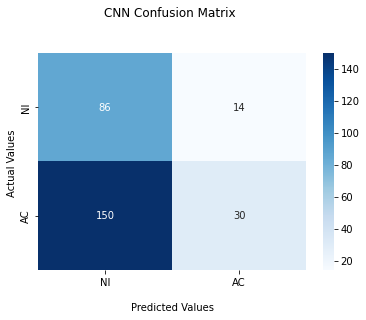

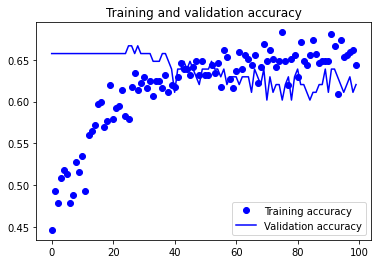

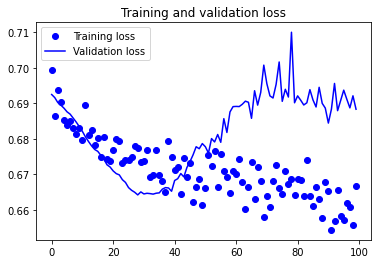

Test loss: 0.7352444529533386
Test accuracy: 0.41428571939468384
**************************************************
**************************************************
Subject 13
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - 2s 121ms/step - loss: 0.7033 - accuracy: 0.6065 - val_loss: 0.6937 - val_accuracy: 0.3241
Epoch 2/100
14/14 [==============================] - 1s 102ms/step - loss: 0.6925 - accuracy: 0.6088 - val_loss: 0.6939 - val_accuracy: 0.3241
Epoch 3/100
14/14 [==============================] - 1s 100ms/step - loss: 0.6923 - accuracy: 0.5903 - val_loss: 0.6940 - val_accuracy: 0.3241
Epoch 4/100
14/14 [==============================] - 1s 102ms/step - loss: 0.6947 - accuracy: 0.6111 - val_loss: 0.6947 - val_accuracy: 0.3241
Epoch 5/100
14/14 [==============================] - 1s 102ms/step - loss: 0.6921 - accuracy: 0.5787 - val_loss: 0.6948 - val_accuracy: 0.3241
Epoch 6/100
14/14 [==============================] - 1s 103ms/step - loss: 0.6935 - accuracy: 0.5394 - val_loss: 0.6949 - val_accuracy: 0.3241
Epoch 7/100
14/14 [==============================] - 1s 104ms/step - loss: 0.6873 - accuracy: 0.5648 - val_loss: 0.6946 - val_accuracy: 0.3241
Epoch 8/100

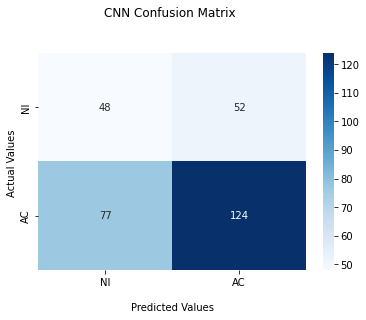

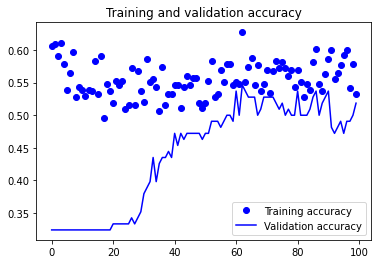

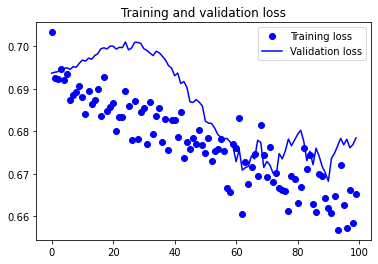

Test loss: 0.682053804397583
Test accuracy: 0.5714285969734192
**************************************************


In [23]:
for i in range(14):
  print('**************************************************')
  print('Subject', i)
  train_X, test_X, train_y, test_y = get_train_test(active_au[i], passive_au[i], cue_au[i])

  # LDA
  # clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
  # vis_confusion_matrix(cm_lda)

  model = get_model("eegnet")

  #CNN
  cnn_model, cnn_train, test_eval, cm_cnn = cnn(model,
                                                train_X,
                                                test_X,
                                                train_y,
                                                test_y,
                                                batch_size = 32,
                                                epochs = 100,
                                                ver = 1)
  
  vis_confusion_matrix(cm_cnn)
  vis_acc_loss(cnn_train)
  print('Test loss:', test_eval[0])
  print('Test accuracy:', test_eval[1])
  print('**************************************************')

In [25]:
res = [0.6428571343421936,
       0.9200000166893005,
       0.46785715222358704,
       0.6071428656578064,
       0.4714285731315613,
       0.5392857193946838,
       0.7142857313156128,
       0.5928571224212646,
       0.574999988079071,
       0.7535714507102966,
       0.5392857193946838,
       0.8714285492897034,
       0.41428571939468384,
       0.5714285969734192]

print(np.mean(res))

0.620051024215562
